# **<span style = 'color:blue'>Generalized additive model for predicting Smart Homes Indoor Temperature</span>**
## **<span style='color:green'> Contents:</span>**<a id="Table"></a>

* [1. Import the libraries](#Import)
* [2. Dataset Information](#Dataset)
* [3. Adversarial Validation](#Adversarial)
* [4. Feature Engineering & Data preprocessing](#Engineering)
    > * [4.1 Feature Extraction](#Extraction)
    > * [4.2 Train Validation split](#Split)
* [5. Build & Train  Generalized additive model (GAM) with pyGAM](#GAM)
    > * [Partial dependency plots](#dependency-plot)
* [6. GAM Model Evaluation & Diagnostics](#GAM-Evaluation)
    > * [6.1 Evaluation Metrics](#Metrics)
    > * [6.2 Residual Plots](#Residual)
    > * [6.3 Normality Test for Residuals](#Normality)
    > * [6.4 Heteroscedasticity Analysis of Residuals: Breusch-Pagan, Goldfeld-Quandt and White Tests in Python](#Heteroscedasticity)
* [7. Model Prediction & Kaggle Submission](#Prediction)
* [8. Concluding remarks](#Conclusion)
* [9. References](#References)
* [10. Extension: LinearBoostRegressor](#LinearBoostRegressor)
* [11. Extension: All regression models in one frame](#regression)

## **<span style = 'color:green'>1. Import the required libraries</span>**<a id ="Import"></a>

In [1]:
# Import data handling & numerical libraries
import pandas as pd
import numpy as np
from copy import copy
import datetime

# Import Data Visualization libraries
import seaborn as sb
import matplotlib.pyplot as plt

#import libraries for muting unnecessary warnings if needed
import warnings
warnings.filterwarnings('ignore')

## **<span style = 'color:green'>2. Dataset information</span>**<a id ='Dataset'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

The dataset collected from the monitor system mounted in a solar house corresponds to approximately 40 days of monitoring data. The Goal is to predict indoor temperature of a room (the Bedroom), in order to choose whether or not to activate the HVAC (Heating, Ventilation, and Air Conditioning) system. The data was sampled every minute, computing and uploading it smoothed with 15 minute means. The dataset includes dates, other sensor measurements, weather measurements and other information. It is a multivariate time-series dataset. It has been established that the power consumption attributed to HVAC accounts for 53.9 % of total consumption, and the energy required to maintain the temperature is less than that required to drop or raise it. As a result, a predictive model capable of predicting a room's indoor temperature (a short-term forecast of indoor temperature) would help in lowering overall energy consumption, by deciding whether or not to activate the HVAC system, at the appropriate time. Below displayed map provides an idea of locations of solar house sensors and actuators.

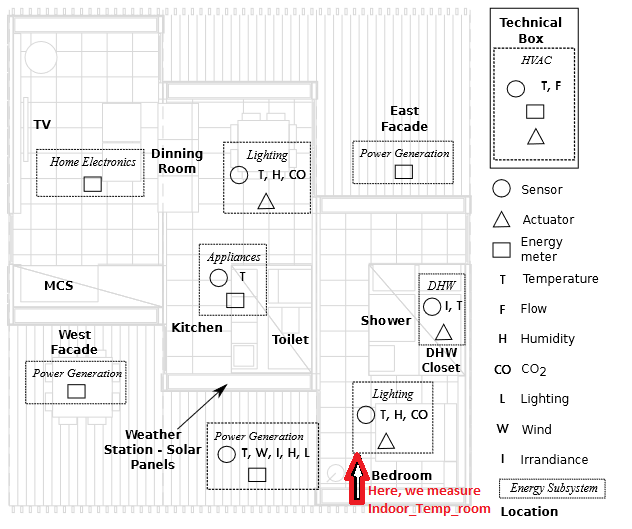

In [2]:
from IPython.display import Image
url = '/content/Solar house sensors and actuators map.png'
Image(url,width=700, height=700)

In [3]:
#Reading datasets
df_train=pd.read_csv("/content/train.csv")
df_test=pd.read_csv("/content/test.csv")

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Id                                2764 non-null   int64  
 1   Date                              2764 non-null   object 
 2   Time                              2764 non-null   object 
 3   CO2_(dinning-room)                2764 non-null   float64
 4   CO2_room                          2764 non-null   float64
 5   Relative_humidity_(dinning-room)  2764 non-null   float64
 6   Relative_humidity_room            2764 non-null   float64
 7   Lighting_(dinning-room)           2764 non-null   float64
 8   Lighting_room                     2764 non-null   float64
 9   Meteo_Rain                        2764 non-null   float64
 10  Meteo_Sun_dusk                    2764 non-null   float64
 11  Meteo_Wind                        2764 non-null   float64
 12  Meteo_

In [5]:
df_train.describe()

,Id,CO2_(dinning-room),CO2_room,Relative_humidity_(dinning-room),Relative_humidity_room,Lighting_(dinning-room),Lighting_room,Meteo_Rain,Meteo_Sun_dusk,Meteo_Wind,Meteo_Sun_light_in_west_facade,Meteo_Sun_light_in_east_facade,Meteo_Sun_light_in_south_facade,Meteo_Sun_irradiance,Outdoor_relative_humidity_Sensor,Day_of_the_week,Indoor_temperature_room
count,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000,2764.000000
mean,1381.500000,208.479123,211.065844,44.878420,47.321220,26.745381,40.732571,0.047033,325.369289,1.108531,14936.617682,12248.000148,22047.525813,215.010017,55.981988,3.954438,18.824852
std,798.042397,27.032686,28.469144,6.587440,7.557795,23.298441,42.326087,0.206705,305.062614,1.161283,25964.049455,21758.550527,32709.387051,297.234046,13.019610,1.991799,2.821178
min,0.000000,187.339000,188.907000,27.084000,29.594700,10.740000,11.328000,0.000000,0.606667,0.000000,0.000000,0.000000,0.000000,-4.164670,22.260700,1.000000,11.076000
25%,690.750000,200.893250,202.682750,40.351975,42.531325,11.588700,13.265300,0.000000,0.650000,0.094833,0.000000,0.000000,0.000000,-3.381330,46.430675,2.000000,17.060350
50%,1381.500000,207.045500,209.408000,45.434650,47.534700,11.801300,17.690000,0.000000,611.797000,0.659000,0.000000,0.000000,0.000000,3.922000,57.477350,4.000000,19.021000
75%,2072.250000,211.245500,213.218750,49.352675,52.685975,31.224000,52.057350,0.000000,619.210750,1.971497,15088.000000,11131.275000,38736.575000,435.434500,65.649325,6.000000,20.828700
max,2763.000000,594.389000,609.237000,60.957300,62.594700,110.693000,162.965000,1.000000,624.960000,6.321330,95278.400000,85535.400000,95704.400000,1028.270000,83.805300,7.000000,24.944000


To make sure that the dataset does not contain any missing values and/or duplicates create a complete list of DaTime with 15 minutes interval from the starting to end point and check whether it matches with the index list of dataset.

In [6]:
# sort by dates
df_train.sort_index(inplace = True)

#creating datetime list with boundaries of raw data series, hourly frequency
datelist = pd.date_range(datetime.datetime(2012,3,13,11,45,0), datetime.datetime(2012,4,11,6,30,0), freq='15min').tolist()

#extracting raw data series indices
idx_list = df_train.index.to_list()

#checking for anomalies by comparing the two
print(idx_list == datelist)
#searching for anomalies
print("\n No. of elements in full list:", len(datelist), "\n No. of indices:", len(idx_list), "\n No. of elements in set of indices:", len(set(idx_list)))


False

 No. of elements in full list: 2764 
 No. of indices: 2764 
 No. of elements in set of indices: 2764


In [7]:
import plotly.express as px
fig = px.line(df_train['Indoor_temperature_room'])
fig.show()

## **<span style = 'color:green'>Adversarial Validation</span>**<a id ='Adversarial'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

Adversarial Validation is to check whether both the training and the test datasets come from the independent and identically distributed (IID) samples. This is done by classifying and encoding them  into a separate feature classes by giving labels such as 0 for the training data and 1 for the test data, mix them up, and then do a classification analysis to check if we are able to correctly re-identify them using a binary classifier. More on Adversaial Validation can be read from [here](https://www.kaggle.com/code/carlmcbrideellis/what-is-adversarial-validation/notebook)

In [8]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv
# drop the target column from the training data
train = df_train.drop(['Id', 'Indoor_temperature_room', 'Date', 'Time'], axis=1)
test = df_test.drop(['Id', 'Date', 'Time'], axis = 1)
# select only the numerical features
# add the train/test labels
train["AV_class"] = 0
test["AV_class"]  = 1

# make one big dataset
train_test = pd.concat([train, test], axis=0, ignore_index=True)

# shuffle
train_test_shuffled = train_test.sample(frac=1)

# create our DMatrix (the XGBoost data structure)
X = train_test_shuffled.drop(['AV_class'], axis=1)
y = train_test_shuffled['AV_class']
XGBdata = xgb.DMatrix(data=X,label=y)

# our XGBoost parameters
params = {"objective":"binary:logistic",
          "eval_metric":"logloss",
          'learning_rate': 0.05,
          'max_depth': 5, }

# perform cross validation with XGBoost
cross_val_results = cv(dtrain=XGBdata, params=params, 
                       nfold=5, metrics="auc", 
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)

# print out the final result
print((cross_val_results["test-auc-mean"]).tail(1))

199    0.999729
Name: test-auc-mean, dtype: float64


AUC of 0.999735 indicates that the classifier is able to perfectly distinguish between the original training and test data. This means that both training and testing data are clearly distinguishable from each other.  Feature importance plot gives an idea of that particular feature that contributes the most to the separation of training and testing data. 

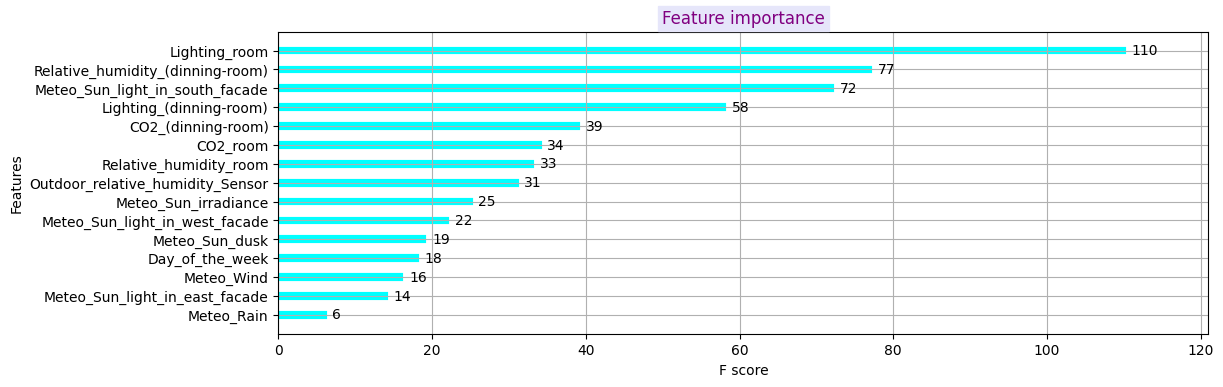

In [9]:
classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False)
classifier.fit(X, y)
fig, ax = plt.subplots(figsize=(12,4),dpi=100)
plt.title('Feature Importances', size = 18, color='purple', loc='center', backgroundcolor='lavender', pad='10.0')
plot_importance(classifier, ax=ax, color='#087E8B', edgecolor= 'cyan', linewidth=3)
plt.show();

Since all features are equally important in predicting indoor tempearture it is not possible to drop any of the above features. A more detailed analysis using normality tests determine how likely a data sample is from a normally distributed population using p-values. The null hypothesis for each test is that “the sample came from a normally distributed population”.

In [10]:
from scipy import stats
features_list = test.columns.values.tolist()
for feature in features_list:
    statistic, pvalue = stats.kstest(train[feature], test[feature]) #Kolmogorov-Smirnov test 
    print("p-value %.2f" %pvalue, "for the feature",feature)

p-value 0.00 for the feature CO2_(dinning-room)
p-value 0.00 for the feature CO2_room
p-value 0.00 for the feature Relative_humidity_(dinning-room)
p-value 0.00 for the feature Relative_humidity_room
p-value 0.00 for the feature Lighting_(dinning-room)
p-value 0.00 for the feature Lighting_room
p-value 0.52 for the feature Meteo_Rain
p-value 0.00 for the feature Meteo_Sun_dusk
p-value 0.00 for the feature Meteo_Wind
p-value 0.00 for the feature Meteo_Sun_light_in_west_facade
p-value 0.00 for the feature Meteo_Sun_light_in_east_facade
p-value 0.00 for the feature Meteo_Sun_light_in_south_facade
p-value 0.00 for the feature Meteo_Sun_irradiance
p-value 0.00 for the feature Outdoor_relative_humidity_Sensor
p-value 0.96 for the feature Day_of_the_week
p-value 0.00 for the feature AV_class


All the above p-values for Kolmogorov-Smirnov normality tests returned an alpha value less than 0.05, which means that the null hypothesis is to be rejected with 95% confidence level and it is likely that the data points do not come from a normal distribution. These features have completely different distributions between the training and the test datasets. The below displayed plot gives a visual experience of difference of distribution between training and testing data sets. 

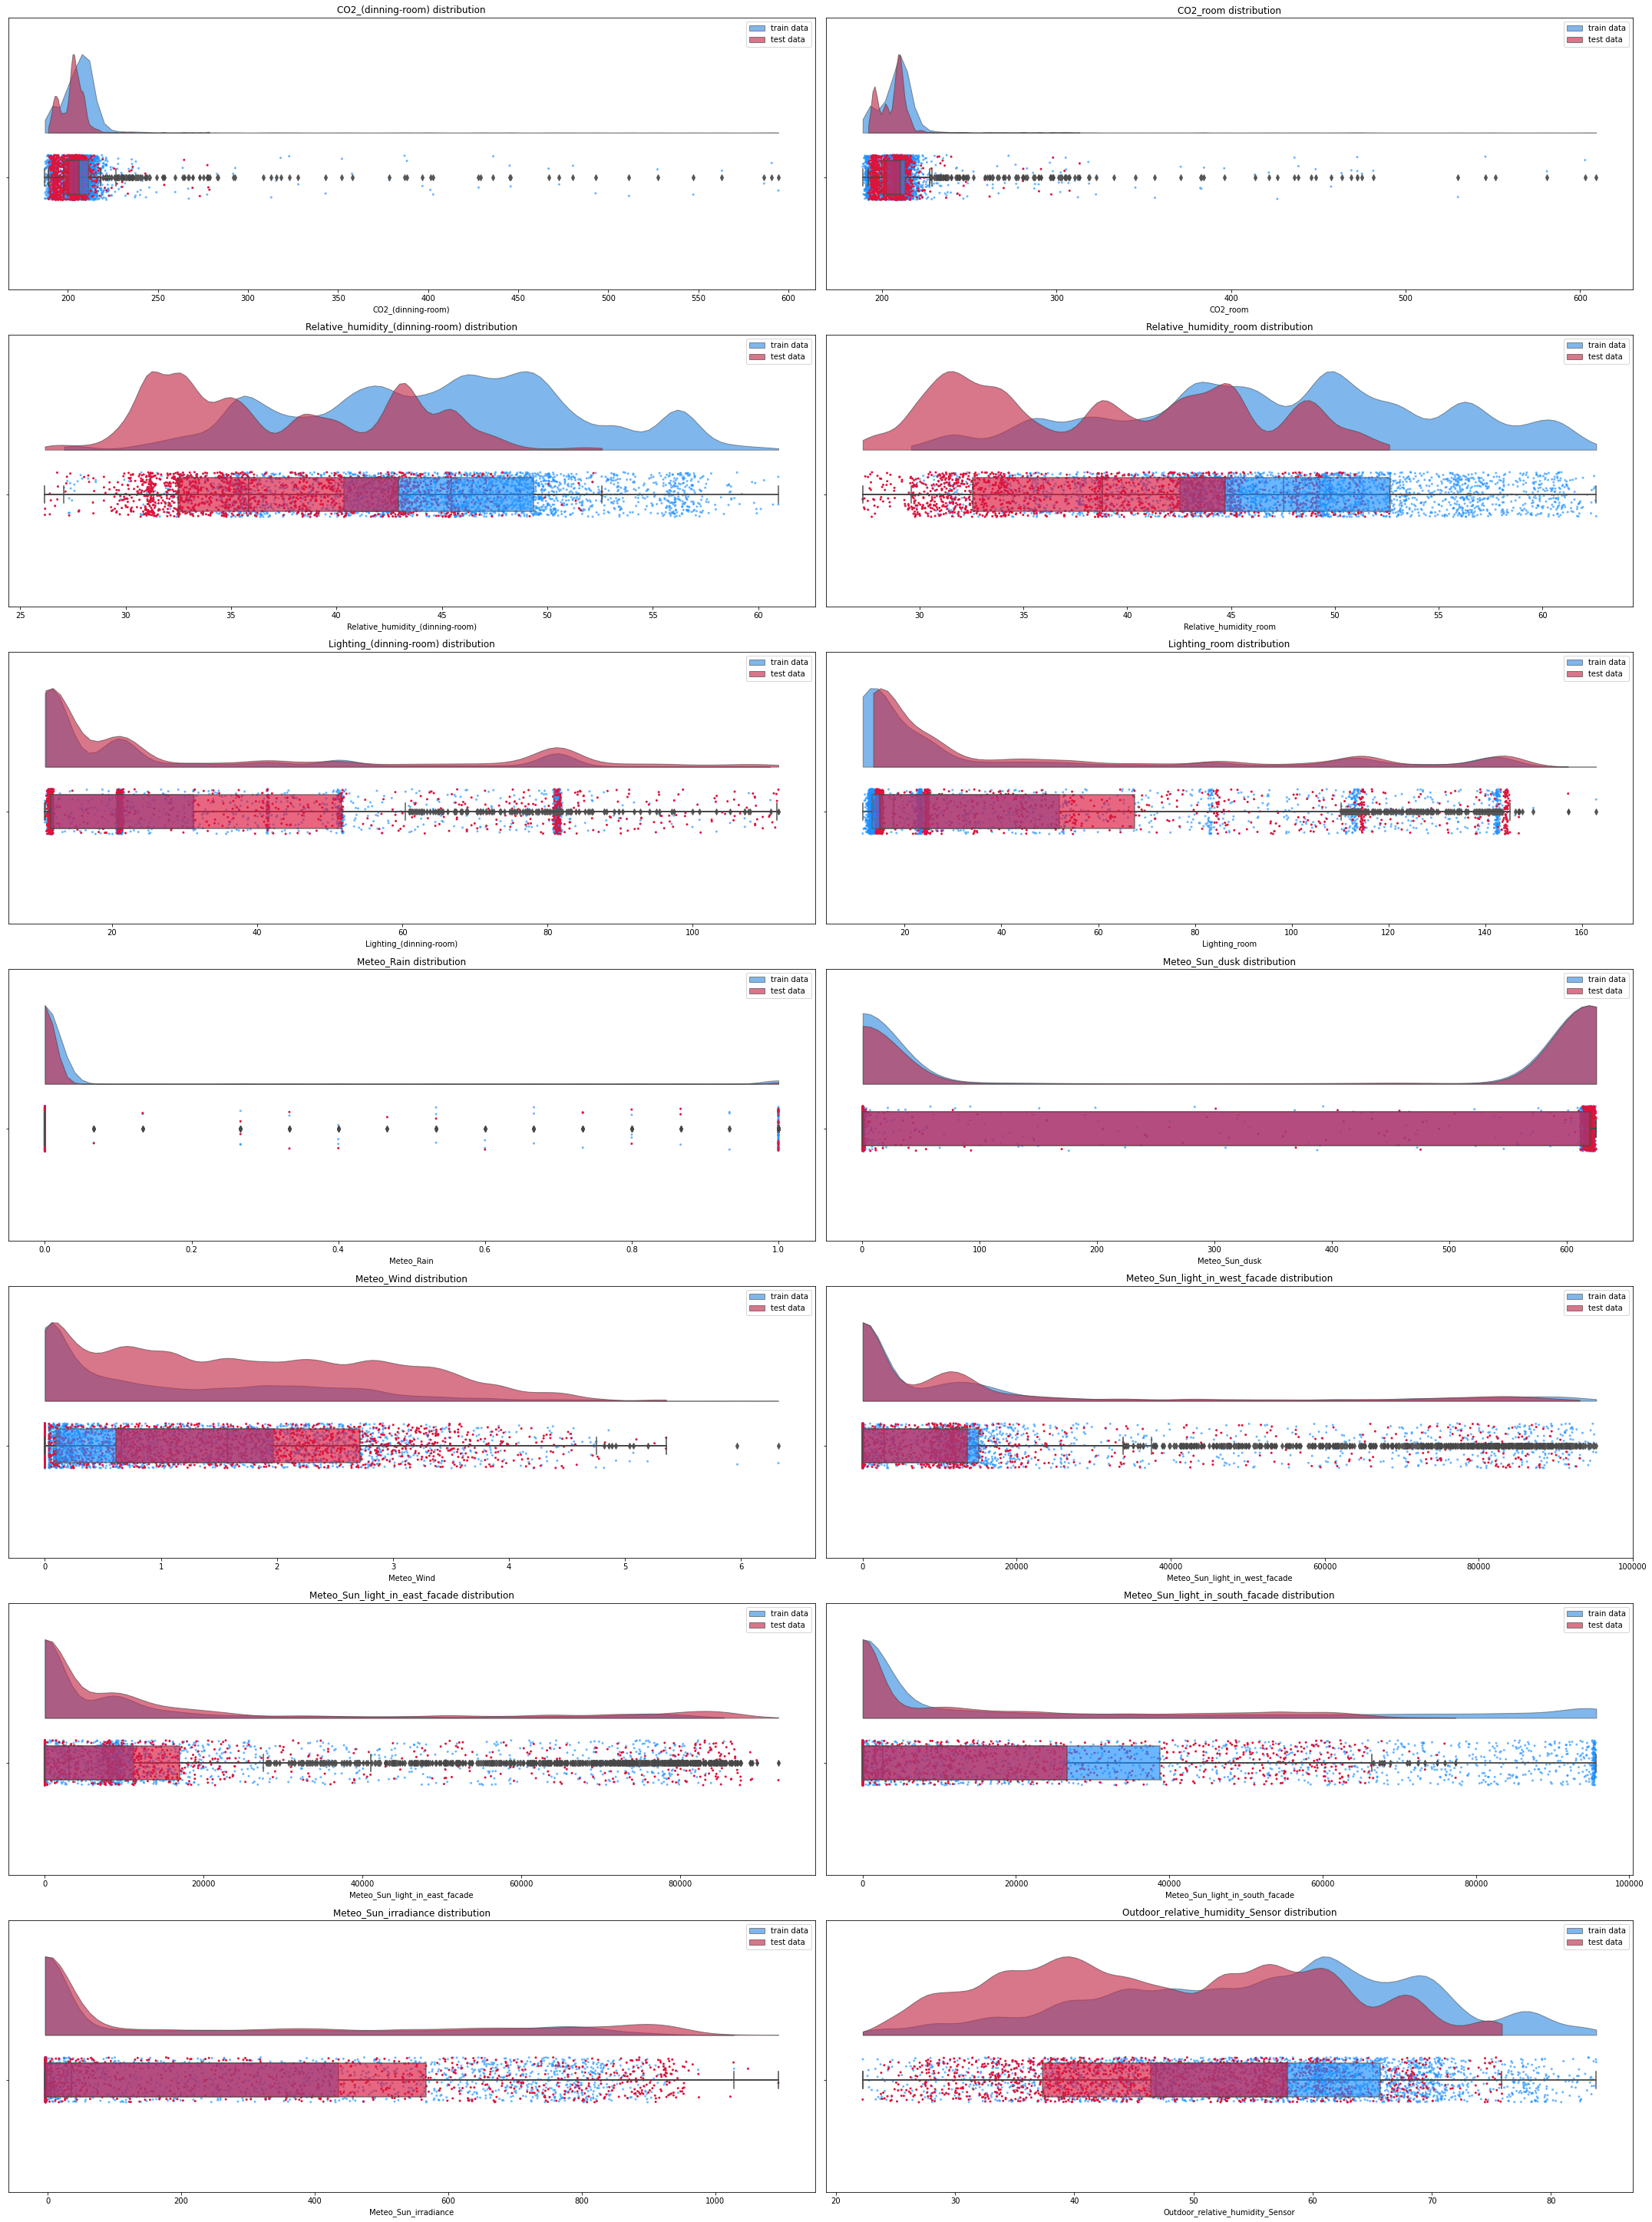

In [11]:
!pip install -q ptitprince
import ptitprince as pt
num_feats=[col for col in df_test.columns if df_test[col].dtypes != 'object'  and col !='Day_of_the_week' and col != 'Id']
fig=plt.figure(figsize=(30,80))
for i, col in enumerate(num_feats):
    plt.subplot(len(num_feats),2,1*i+1)
    pt.RainCloud(data=df_train, y=df_train[col], bw=0.1, cut=0, hue=['dodgerblue'], orient='h', label="train data", palette=['dodgerblue'], alpha = .65)
    pt.RainCloud(data=df_test,  y=df_test[col], bw=0.1, cut=0, orient='h',label="test data", hue=['crimson'], palette=['crimson'], alpha = .65)
    legend = plt.legend()
    plt.title(f'{col} distribution')
plt.tight_layout()

When the training data is completely different from testing data, it becomes impossible to predit a test data target value from a train data feature and target values. In this case The target values of test data lie outside of the range of the target values it was originally trained on.

In [12]:
df_train.Date.unique(), df_test.Date.unique()

(array(['13/03/2012', '14/03/2012', '15/03/2012', '16/03/2012',
        '17/03/2012', '18/03/2012', '19/03/2012', '20/03/2012',
        '21/03/2012', '22/03/2012', '23/03/2012', '24/03/2012',
        '25/03/2012', '26/03/2012', '27/03/2012', '28/03/2012',
        '29/03/2012', '30/03/2012', '31/03/2012', '01/04/2012',
        '02/04/2012', '03/04/2012', '04/04/2012', '05/04/2012',
        '06/04/2012', '07/04/2012', '08/04/2012', '09/04/2012',
        '10/04/2012', '11/04/2012'], dtype=object),
 array(['18/04/2012', '19/04/2012', '20/04/2012', '21/04/2012',
        '22/04/2012', '23/04/2012', '24/04/2012', '25/04/2012',
        '26/04/2012', '27/04/2012', '28/04/2012', '29/04/2012',
        '30/04/2012', '01/05/2012', '02/05/2012'], dtype=object))

As can be seen above the train data contains features captured on end of winter and start of spring season and test data contain features from end of spring and beginning of summer months. Training on this type of data will never return a prediction value outside of what the model has seen in training data while using ensemble tree based regression models.  This can result in erroneous predictions on unseen data. Here comes the importance of linear regression models which can extrapolate the prediction values beyond the prediction intervals of training data.  

## **<span style='color:green'>Feature Engineering & Data preprocessing </span>**<a id ='Engineering'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

### **<span style = 'color:brown'>Feature Extraction</span>**<a id ='Extraction'></a>

1. Having a feature giving special importance to seasons is required because of the significance in difference that may arise in data collected in different months. 

2. From Solar house sensors and actuators map displayed above, it is clearly visible that the room is exposed to sunlight from east, west and south facades. Hence the heating effect from sunlight would be the combined effect of all three. The distribution plots also confirms the fact that they have similar distribution pattern. Instead of taking them as separate, it would be better to take the average of these three.

3. CO2 dining and CO2 room also shows a similarity between each other. Hence those features are also averaged and combined into one. 

3. Extracting a minute feature is also important, its importance will be demonstrated further in the analysis after generating this feature. 

In [13]:
# To extract seasons
def month2seasons(x):
    if x in [12, 1, 2, 3]:
        season = 0
    elif x in [6, 7, 8]:
        season = 1
    elif x in [4, 5]:
        season = 2
    elif x in [9, 10, 11]:
        season = 3
    return season

for df in (df_train, df_test):
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')   
    df['DateTime'] = df['Date'] + ' ' + df['Time']
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['hour'] = df['DateTime'].apply(lambda x : x.hour)
    df['Month'] = df['DateTime'].apply(lambda x : x.month)
    df['Minutes']=df['DateTime'].apply(lambda x: x.hour *60 + x.minute).astype(float)
    df["CO2_avg"] = (df["CO2_(dinning-room)"] + df["CO2_room"])/2 # To extract average of CO@ features
    # To extract average of Meteo Sun light features
    df['Meteo_Sun_light_AVG'] = (df['Meteo_Sun_light_in_west_facade'] + df['Meteo_Sun_light_in_east_facade'] + df['Meteo_Sun_light_in_south_facade'])/3
    df['Season'] = df['Month'].apply(month2seasons)
    df.drop(['Day_of_the_week', 'Date','Time', "CO2_(dinning-room)", "CO2_room", 'Month','Meteo_Sun_light_in_west_facade',
        'Meteo_Sun_light_in_east_facade', 'Meteo_Sun_light_in_south_facade'], axis = 1, inplace = True)
df_train.shape, df_train.columns

((2764, 17),
 Index(['Id', 'Relative_humidity_(dinning-room)', 'Relative_humidity_room',
        'Lighting_(dinning-room)', 'Lighting_room', 'Meteo_Rain',
        'Meteo_Sun_dusk', 'Meteo_Wind', 'Meteo_Sun_irradiance',
        'Outdoor_relative_humidity_Sensor', 'Indoor_temperature_room',
        'DateTime', 'hour', 'Minutes', 'CO2_avg', 'Meteo_Sun_light_AVG',
        'Season'],
       dtype='object'))

The following steps are done to demonstrate the importance of minutes columns. For this, first the dataset is grouped to get mean temperature for each 15 minute interval.

In [14]:
minutes=df_train[['Indoor_temperature_room','Minutes']].groupby(['Minutes']).mean().reset_index()
minutes.columns = ['Minutes', 'mean_temp']
#minutes['Minutes']= minutes['Minutes'].astype(int)
scaled_temp = minutes['mean_temp'] - minutes['mean_temp'].mean()

Plotting mean temperature versus minutes.

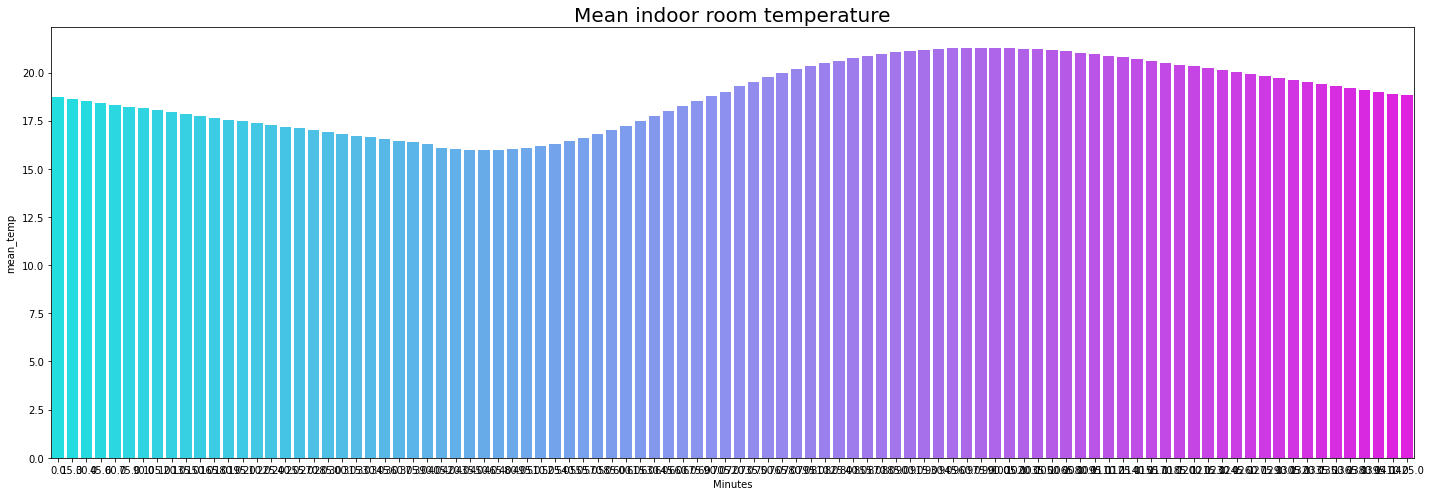

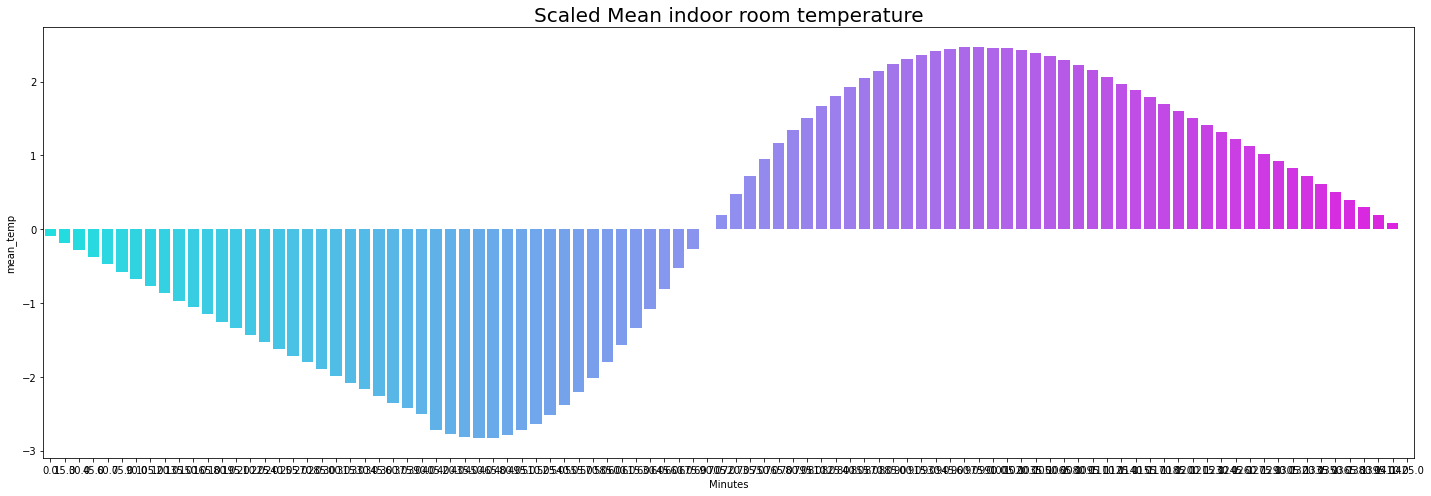

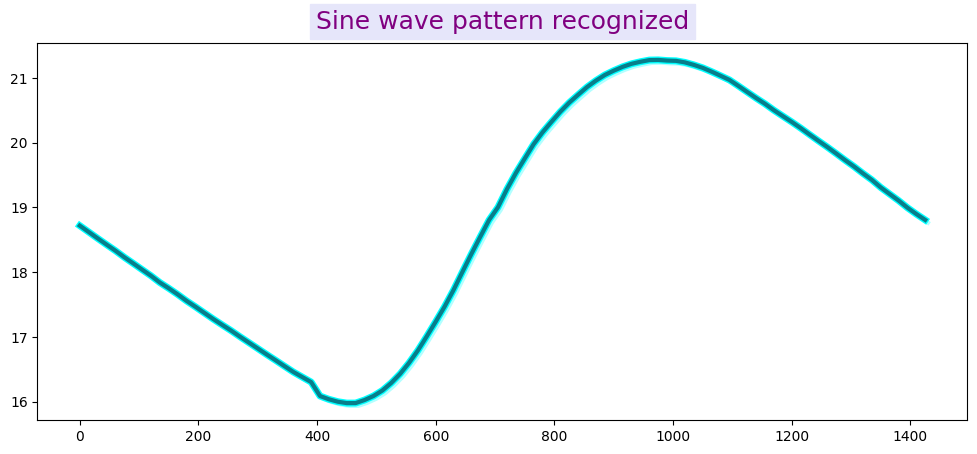

In [15]:
# Define a function to plot the entire dataframe to performs data visualization
def display_plot(x, y, fig_title):
    plt.figure(figsize = (20,7))
    plt.title(fig_title, loc='center', fontsize=20)
    sb.barplot(x = x, y = y, palette = 'cool') 
    plt.tight_layout();
display_plot(minutes['Minutes'],minutes['mean_temp'], "Mean indoor room temperature")
display_plot(minutes['Minutes'],scaled_temp, "Scaled Mean indoor room temperature")

fig,ax=plt.subplots(figsize = (12,5),dpi=100)
#ax.plot(minutes['Minutes'],minutes['mean_temp'])
import matplotlib.patheffects as pe
ax.plot(minutes['Minutes'],minutes['mean_temp'], lw = 3, color='#087E8B', 
         path_effects=[pe.SimpleLineShadow(shadow_color='cyan'), pe.Stroke(linewidth=5, foreground='cyan'),pe.Normal()])
plt.title('Sine wave pattern recognized', loc = 'Center', fontsize=18, color='purple', style='normal', backgroundcolor='lavender', pad='10.0')
plt.show()


Obviously a sinosoidal wave pattern with respect to daily period, , which is quite similar to the pattern generated from a sine function as in the following

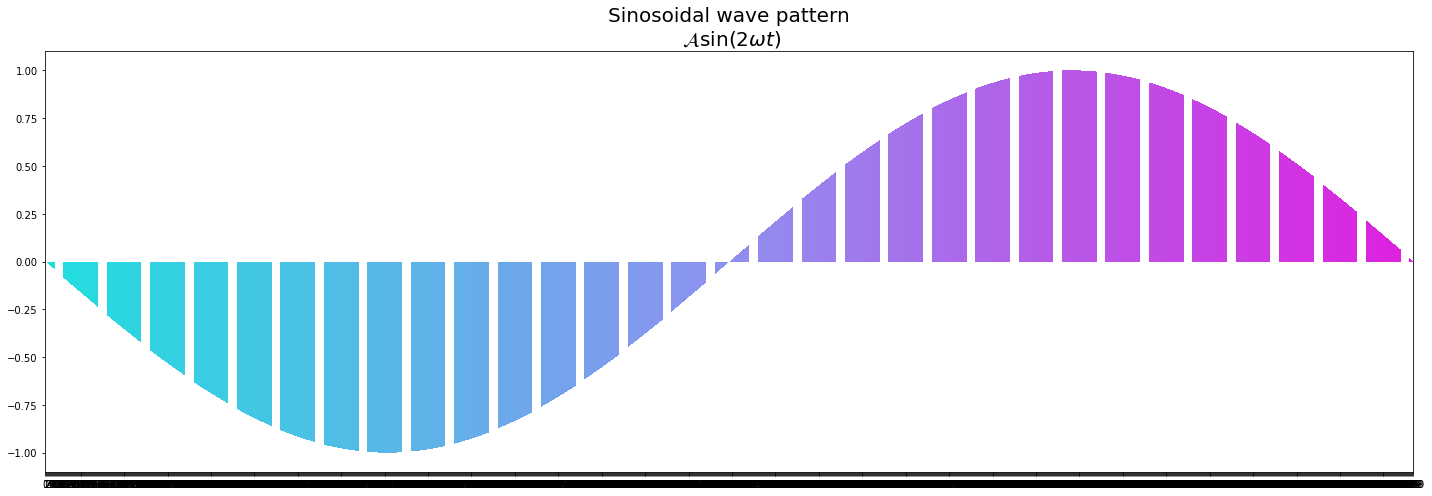

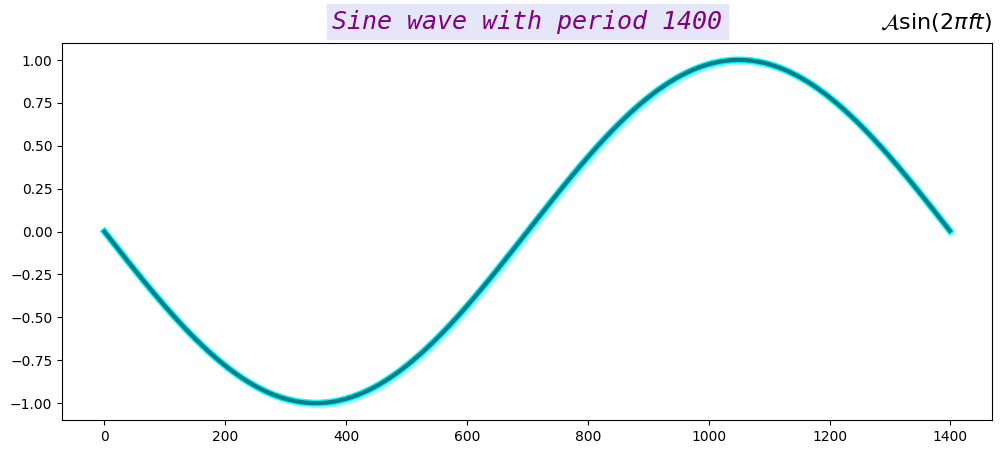

In [16]:
a1=np.arange(0,1400)
a2=-np.sin(2*np.pi*a1/1400) # sin (2pift)
display_plot(a1,a2, "Sinosoidal wave pattern\n $\mathcal{A}\mathrm{sin}(2 \omega t)$")
fig,ax=plt.subplots(figsize = (12,5),dpi=100)
ax.plot(a1,a2, lw = 3, color='#087E8B', 
         path_effects=[pe.SimpleLineShadow(shadow_color='cyan'), pe.Stroke(linewidth=5, foreground='cyan'),pe.Normal()])
mono_font = {'fontname':'monospace'}
plt.title('Sine wave with period 1400', loc = 'Center', fontsize=18, **mono_font,
          color='purple', style='oblique', backgroundcolor='lavender', pad='10.0')
plt.title("$\mathcal{A}\mathrm{sin}(2 \pi f t)$", fontsize=16, loc = 'right', pad='10.0')
plt.show()

### **<span style = 'color:brown'>Train Validation split</span>**<a id ='Split'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

In [17]:
df_train1 = df_train.drop(['Id', 'DateTime','hour'], axis = 1)
X = df_train1.drop('Indoor_temperature_room', axis = 1)
y = df_train1['Indoor_temperature_room']
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle = True, test_size = 0.2)

## **<span style='color:green'>Build & Train  Generalized additive model (GAM) with pyGAM</span>**<a id ='GAM'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
GAM allows us to easily examine the partial relationships between the response variable and the predictors. As the name implies its addictive nature ensures that the partial impact of each variable does not depend on the others in the model.

In [18]:
!pip install pygam
from pygam import LinearGAM
gam = LinearGAM(n_splines=10).fit(X, y)
gam.summary()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     70.3999
Link Function:                     IdentityLink Log Likelihood:                                 -4189.4444
Number of Samples:                         2764 AIC:                                             8521.6885
                                                AICc:                                            8525.5295
                                                GCV:                                                1.2754
                                                Scale:                                               1.217
                                             

### **<span style = 'color:brown'>Partial dependency plots</span>**<a id ='dependency-plot'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

partial dependence functions can be used to inspect the contribution of each feature and demonstrate partial relationships. 

<Figure size 432x288 with 0 Axes>

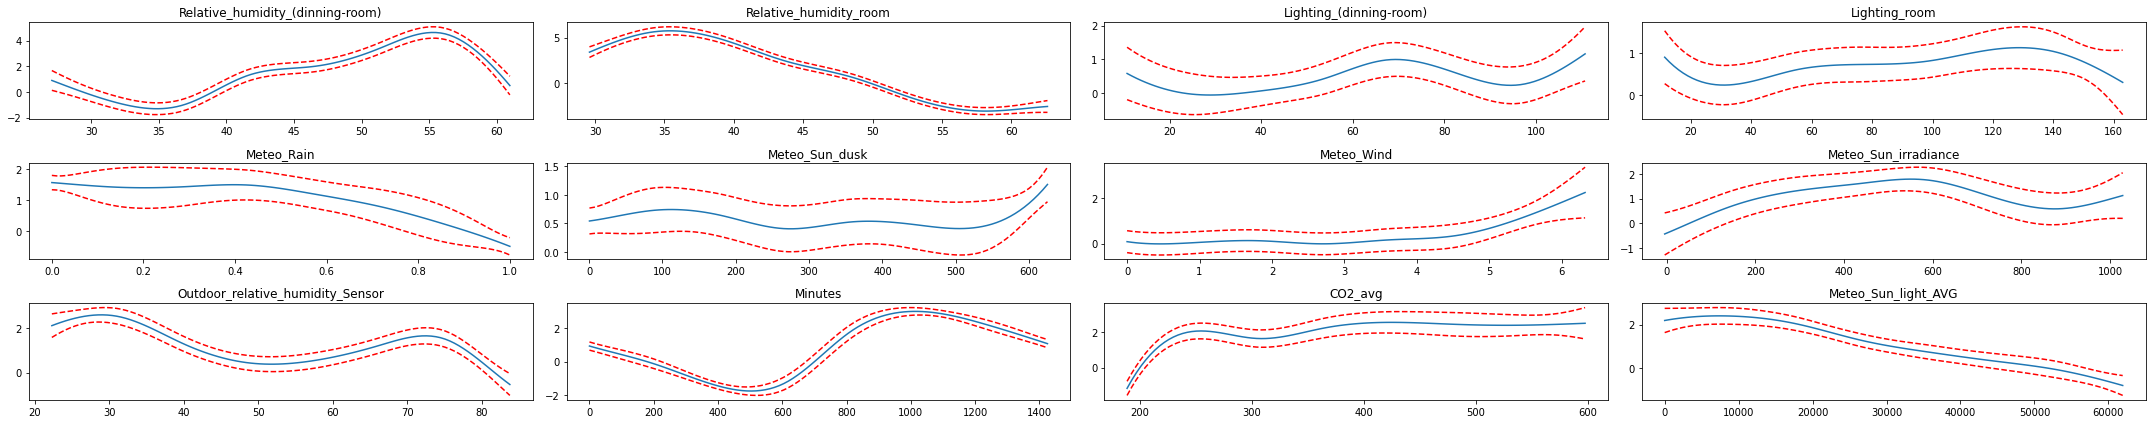

In [19]:
## plotting
plt.figure();
fig, axes = plt.subplots(3,ncols =int(len(X.columns)/3), figsize = (30, 6));

titles = X.columns
for i, (col,ax) in enumerate(zip(X.columns, axes.flatten())):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    #if i == 0:
        #ax.set_ylim(-30,30)
    ax.set_title(titles[i]);
plt.tight_layout()

## **<span style = 'color:green'>6. GAM Model Evaluation & Diagnostics</span>**<a id ='GAM-Evaluation'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
### **<span style = 'color:brown'>6.1 Evaluation Metrics</span>**<a id ='Metrics'></a>

In [20]:
def model_train_evaluation(y, ypred, model_name): 
       
    # Model Evaluation metrics
    from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score, mean_absolute_percentage_error
    print("\n \n Model Evaluation Report: ")
    print('Mean Absolute Error(MAE) of', model_name,':', mean_absolute_error(y, ypred))
    print('Mean Squared Error(MSE) of', model_name,':', mean_squared_error(y, ypred))
    print('Root Mean Squared Error (RMSE) of', model_name,':', mean_squared_error(y, ypred, squared = False))
    print('Mean absolute percentage error (MAPE) of', model_name,':', mean_absolute_percentage_error(y, ypred))
    print('Explained Variance Score (EVS) of', model_name,':', explained_variance_score(y, ypred))
    print('R2 of', model_name,':', (r2_score(y, ypred)).round(2))
    print('\n \n')
    
    # Actual vs Predicted Plot
    f, ax = plt.subplots(figsize=(12,6),dpi=100);
    plt.scatter(y, ypred, label="Actual vs Predicted")
    # Perfect predictions
    plt.xlabel('Indoor Temperature in celsius')
    plt.ylabel('Indoor Temperature in celsius')
    plt.title('Expection vs Prediction')
    plt.plot(y,y,'r', label="Perfect Expected Prediction")
    plt.legend()
    f.text(0.95, 0.06, 'AUTHOR: RINI CHRISTY',
         fontsize=12, color='green',
         ha='left', va='bottom', alpha=0.5);
    
    print('\n \n \n \n')
    fig,ax=plt.subplots(figsize=(15,8))
    plt.plot(y.values, lw = 4, label='Actual values', color = 'blue')
    plt.plot(ypred, label='Predicted values', color = 'red')
    plt.legend(loc='best')
    plt.title(f'Actual vs Predicted for {model_name}')
    plt.show()


#### **<span style = 'color:purple'>6.1.1 Evaluation metrics for n_splines = 10</span>**<a id ="n_splines_10"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)


 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of GAM with n_splines=10 : 0.8742258231315932
Mean Squared Error(MSE) of GAM with n_splines=10 : 1.1860196997947416
Root Mean Squared Error (RMSE) of GAM with n_splines=10 : 1.0890453157673199
Mean absolute percentage error (MAPE) of GAM with n_splines=10 : 0.0481602753144036
Explained Variance Score (EVS) of GAM with n_splines=10 : 0.8509307338563104
R2 of GAM with n_splines=10 : 0.85

 


 
 
 



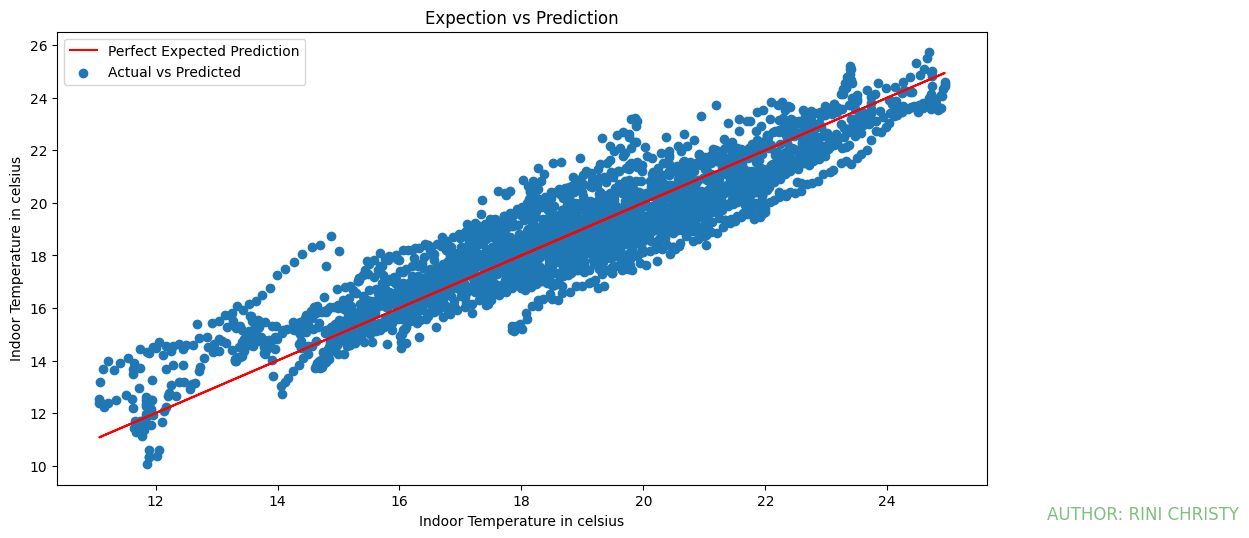

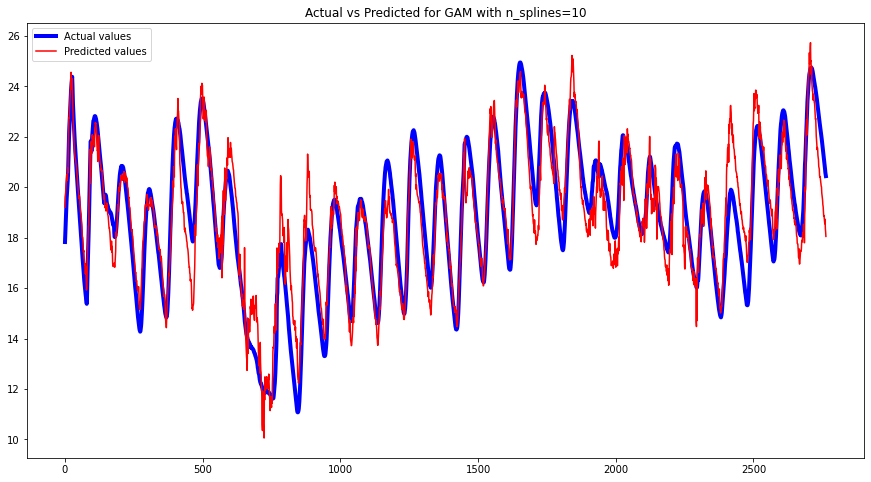

In [21]:
yhat = gam.predict(X)
model_train_evaluation(y, yhat, 'GAM with n_splines=10')

<Figure size 432x288 with 0 Axes>

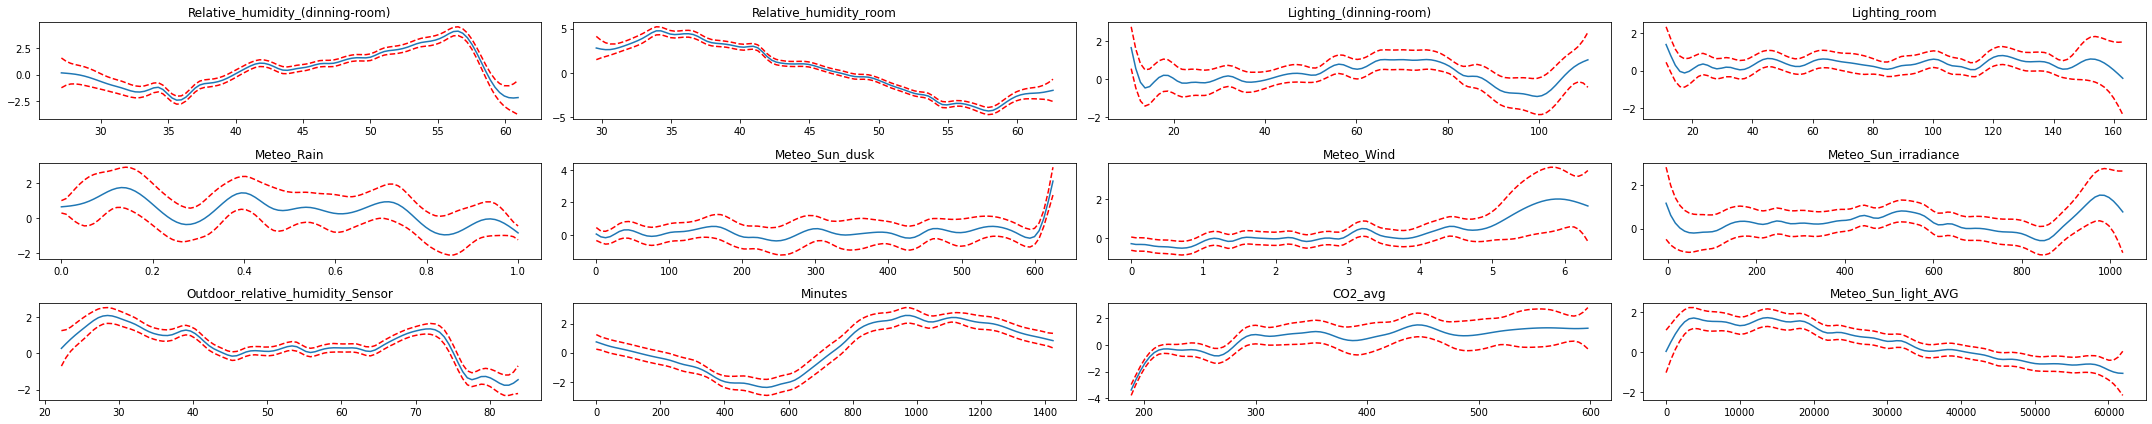

In [22]:
gam = LinearGAM(n_splines=40).fit(X, y)
## plotting
plt.figure();
fig, axes = plt.subplots(3,ncols =int(len(X.columns)/3), figsize = (30, 6));

titles = X.columns
for i, (col,ax) in enumerate(zip(X.columns, axes.flatten())):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    #if i == 0:
        #ax.set_ylim(-30,30)
    ax.set_title(titles[i]);
plt.tight_layout()

#### **<span style = 'color:purple'>6.1.2 Evaluation metrics for n_splines = 40</span>**<a id ="n_splines_40"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)


 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of GAM (n_splines=40) prediction using training set  : 0.7148273510765888
Mean Squared Error(MSE) of GAM (n_splines=40) prediction using training set  : 0.8152685373588864
Root Mean Squared Error (RMSE) of GAM (n_splines=40) prediction using training set  : 0.9029222211015112
Mean absolute percentage error (MAPE) of GAM (n_splines=40) prediction using training set  : 0.038990548304496504
Explained Variance Score (EVS) of GAM (n_splines=40) prediction using training set  : 0.8975299629549481
R2 of GAM (n_splines=40) prediction using training set  : 0.9

 


 
 
 



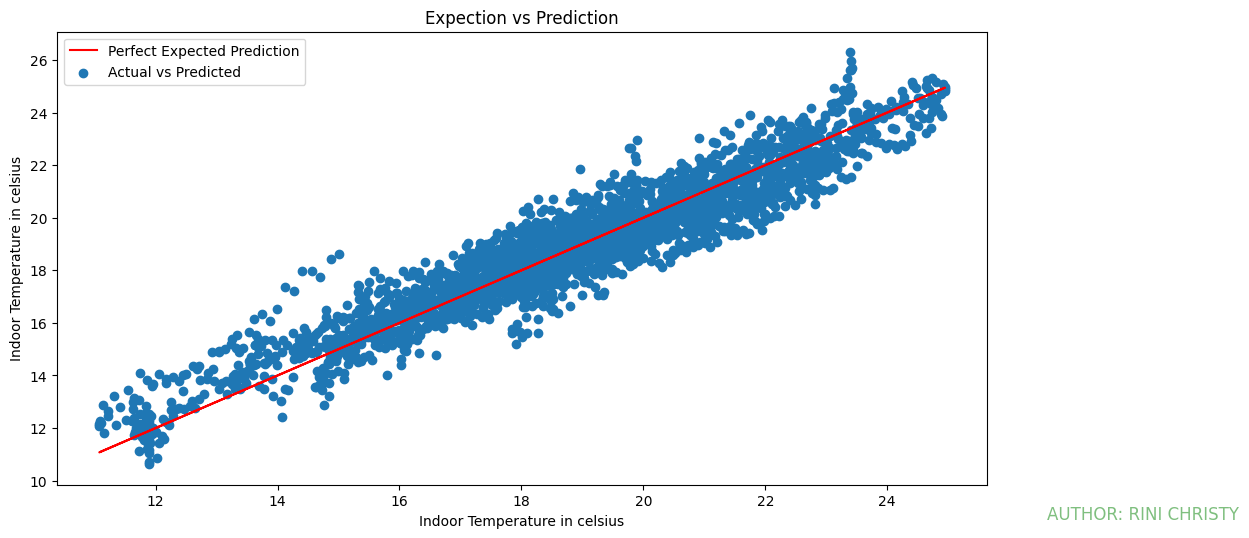

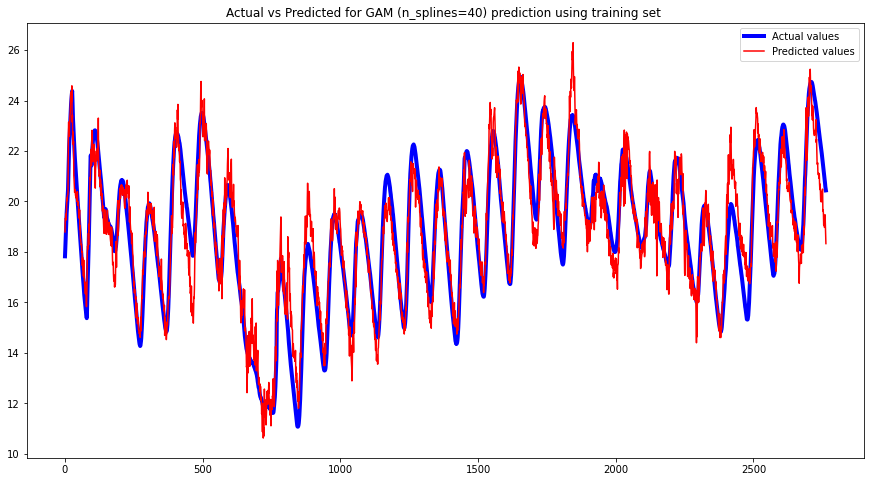

In [23]:
yhat = gam.predict(X)
model_train_evaluation(y, yhat, 'GAM (n_splines=40) prediction using training set ')


 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of GAM prediction using validation set : 0.7156155216418597
Mean Squared Error(MSE) of GAM prediction using validation set : 0.8147862721851779
Root Mean Squared Error (RMSE) of GAM prediction using validation set : 0.9026551236132091
Mean absolute percentage error (MAPE) of GAM prediction using validation set : 0.03876072630803338
Explained Variance Score (EVS) of GAM prediction using validation set : 0.9001819902340041
R2 of GAM prediction using validation set : 0.9

 


 
 
 



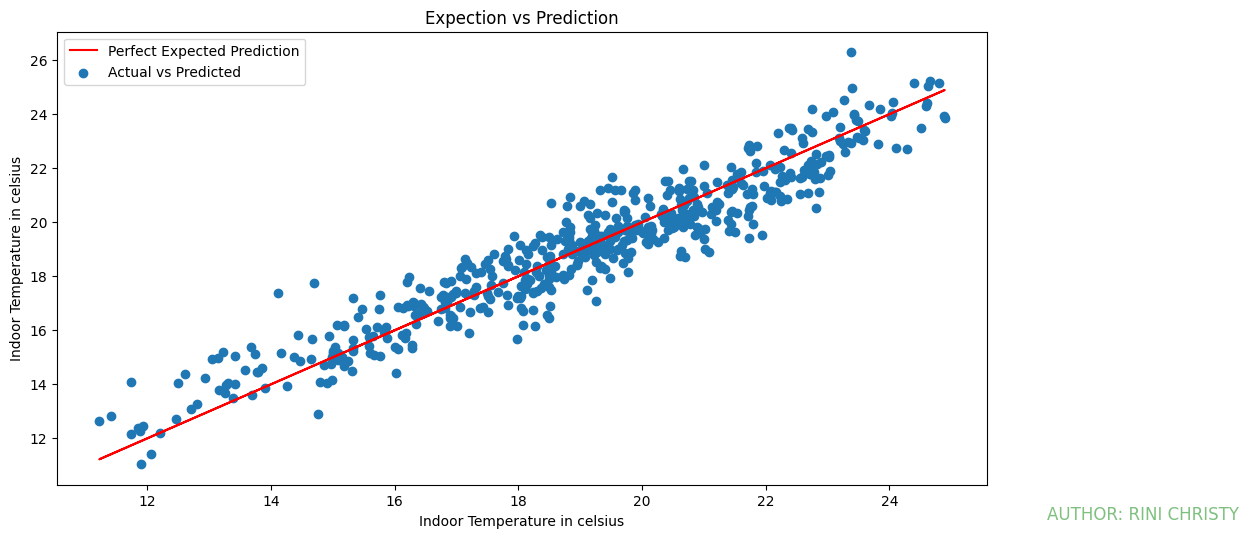

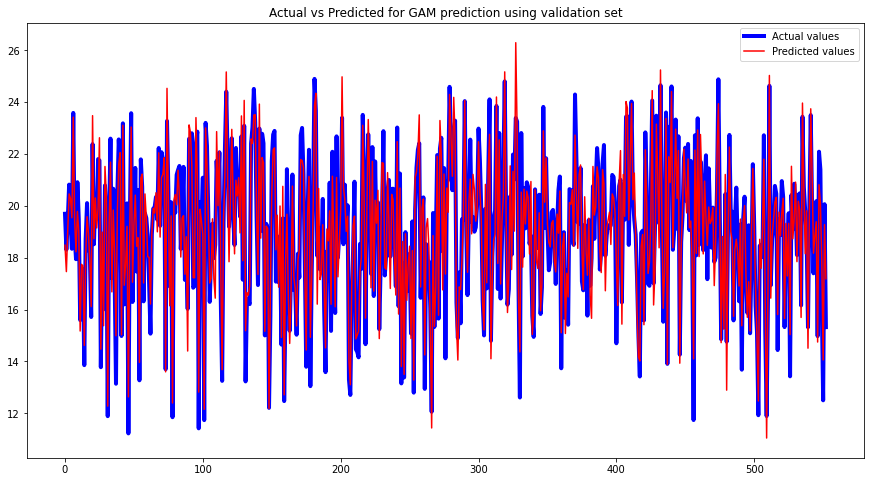

In [24]:
ypred = gam.predict(X_val)
model_train_evaluation(y_val, ypred, 'GAM prediction using validation set')

In [25]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    276.0842
Link Function:                     IdentityLink Log Likelihood:                                 -3639.7163
Number of Samples:                         2764 AIC:                                             7833.6011
                                                AICc:                                            7895.5925
                                                GCV:                                                1.1019
                                                Scale:                                              0.9057
                                                Pseudo R-Squared:                                   0.8975
Feature Function                  Lam

### **<span style = 'color:brown'>6.2 Residual Plots</span>**<a id ='Residual'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
Many of the assumptions that are necessary to have a valid model can be checked by identifying patterns in the residuals of that model. We can make a quick visual check by looking at the residual plot of a given model.
With a residual plot, we look at the predicted values of the model versus the residuals themselves. What we expect to see is just a cloud of unrelated points


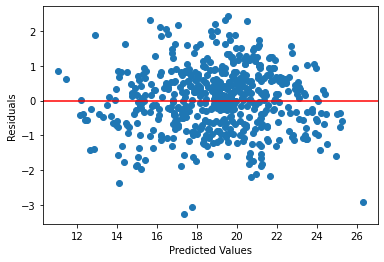

In [26]:
residuals = y_val.values-ypred
plt.scatter(ypred, residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

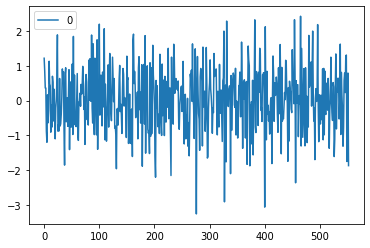

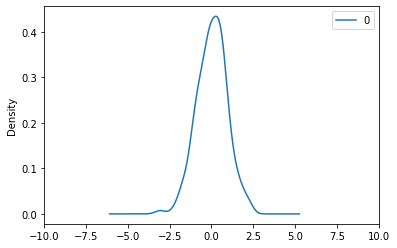

                0
count  553.000000
mean     0.028152
std      0.903033
min     -3.250735
25%     -0.585104
50%      0.063172
75%      0.605224
max      2.417373


In [27]:
# line plot of residuals
residuals = pd.DataFrame(residuals)
residuals.plot()
#plt.ylim(-0.5, 0.5)
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.xlim(-10, 10)
plt.show()
# summary stats of residuals
print(residuals.describe())


### **<span style = 'color:brown'>6.3 Normality Test for Residuals</span>**<a id ='Normality'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

The above residual plots visually confirms that the model satisfies independent and identically distributed (i.i.d) data requirement for residuals. Mathematical confirmation of i.i.d requirement can be executed using normality tests like: Shapiro Wilk test, Kolmogorov-Smirnov test, Jarque-Bera test, Anderson-Darling test (from both scipy and statsmodels), Kolmogorov-Smirnov, and D’Agostino K-squared tests.

The normality tests determine how likely a data sample is from a normally distributed population using p-values. The null hypothesis for each test is that “the sample came from a normally distributed population”. This means that if the resulting p-values are below a chosen alpha value, then the null hypothesis is rejected. Thus there is evidence to suggest that the data comes from a non-normal distribution. For this project, use an Alpha value of 0.01.
The below executed normality tests determine how likely a data sample is from a normally distributed population using p-values. The null hypothesis for each test is that “the sample came from a normally distributed population”.

In [28]:
from scipy import stats
from statsmodels.stats.diagnostic import normal_ad
import statsmodels
sw_result = stats.shapiro(residuals)#Shapiro Wilk test
KS_result = stats.kstest(residuals, 'norm')#Kolmogorov-Smirnov test 
JB_result = stats.jarque_bera(residuals) #Jarque-Bera test
#AD_result = stats.anderson(residuals)#Anderson-Darling test
ad_result = normal_ad(np.array(residuals), axis=0)#Anderson-Darling test
dag_result = stats.normaltest(residuals, axis=0, nan_policy='propagate')#D’Agostino’s K-squared test
lf_result = statsmodels.stats.diagnostic.lilliefors(residuals)#Lilliefors test
#print(f'\n \n Residulas for Indoor_temperature_room')
#print(residuals)
print(f'\n \n Shapiro Wilk test results for Indoor_temperature_room')
print(sw_result)
print(f'\n \n Kolmogorov-Smirnov test results for Indoor_temperature_room')
print(KS_result)
print(f'\n \n Jarque-Bera test results for Indoor_temperature_room')
print(JB_result)
#print(f'\n \n Anderson-Darling test results for Indoor_temperature_room')
#print(AD_result)
print(f'\n \n Anderson-Darling test results for Indoor_temperature_room')
print(ad_result)
print(f'\n \n D’Agostino’s K-squared test results for Indoor_temperature_room')
print(dag_result)
print(f'\n \n Lilliefors test results for Indoor_temperature_room')
print(lf_result)


 
 Shapiro Wilk test results for Indoor_temperature_room
ShapiroResult(statistic=0.995831310749054, pvalue=0.1501251459121704)

 
 Kolmogorov-Smirnov test results for Indoor_temperature_room
KstestResult(statistic=0.9994244635290349, pvalue=0.0)

 
 Jarque-Bera test results for Indoor_temperature_room
Jarque_beraResult(statistic=4.361019082334337, pvalue=0.11298394599910733)

 
 Anderson-Darling test results for Indoor_temperature_room
(array([0.41913185]), array([0.32585623]))

 
 D’Agostino’s K-squared test results for Indoor_temperature_room
NormaltestResult(statistic=array([4.45549184]), pvalue=array([0.10777108]))

 
 Lilliefors test results for Indoor_temperature_room
(0.999858821910599, 0.0)


p values of >0.01 indicates that the null hypothesis cannot be rejected and hence all residuals come from normally distributed sample population. 

### **<span style = 'color:brown'>6.4 Heteroscedasticity Analysis of Residuals: Breusch-Pagan, Goldfeld-Quandt and White Tests in Python</span>**<a id ='Heteroscedasticity'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

Test for heteroskedasticity of standardized residuals

Tests whether the sum-of-squares in the first third of the sample is significantly different than the sum-of-squares in the last third of the sample. Analogous to a Goldfeld-Quandt test. The null hypothesis is of no heteroskedasticity.

#### **<span style = 'color:purple'>6.4.1 Breush-Pagan test</span>**<a id ="Breush-Pagan"></a>
A Breusch-Pagan test uses the following null and alternative hypotheses:

The null hypothesis (H0): Homoscedasticity is present.

The alternative hypothesis: (Ha): Homoscedasticity is not present (i.e. heteroscedasticity exists).

If the p-value of the test results is smaller than alpha (significance level) then we can reject H0 and conclude that the data is heteroscedastic. We will use 0.05 as the signifcance level parameter.

We need to convert y_val into a 2d array since this is required for as one of the input in Breusch-Pagan test


In [29]:
def test_model(col):
    s = []
    for i in col:
        a = [1,i]
        s.append(a)
    return (np.array(s))
Het = df_train.iloc[8:,]

exog = test_model(y_val)
# Method 1
from statsmodels.stats.diagnostic import het_breuschpagan
breusch_pagan_test = het_breuschpagan(residuals, exog)
print(breusch_pagan_test)
print ('\n Het_breuschpagan-test p_value:', breusch_pagan_test[1])
if breusch_pagan_test[1] > 0.05:
    print("The residuals are not heteroscedastic.")
if breusch_pagan_test[1] < 0.05:
    print("The residuals are heteroscedastic.")

(0.8389672887911351, 0.35969229384080204, 0.8372031866393593, 0.3605981273174913)

 Het_breuschpagan-test p_value: 0.35969229384080204
The residuals are not heteroscedastic.


In [30]:
# Method 2
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import statsmodels.tools.tools as smt
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(residuals, exog_het= exog )
lzip(name, test)

[('Lagrange multiplier statistic', 0.8389672887911351),
 ('p-value', 0.35969229384080204),
 ('f-value', 0.8372031866393593),
 ('f p-value', 0.3605981273174913)]

#### **<span style = 'color:purple'>6.4.2 Goldfeld-Quandt test</span>**<a id ="Goldfeld-Quandt"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

In [31]:
name = ["F statistic", "p-value"]
GQ_test = sms.het_goldfeldquandt(residuals, exog)
print(lzip(name, test))
if GQ_test[1] > 0.05:
    print("The residuals are not heteroscedastic.")
if GQ_test[1] < 0.05:
    print("The residuals are heteroscedastic.")

[('F statistic', 0.8389672887911351), ('p-value', 0.35969229384080204)]
The residuals are heteroscedastic.


#### **<span style = 'color:purple'>6.4.3 White test</span>**<a id ="White"></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
White’s test uses the following null and alternative hypotheses:

Null (H0): Homoscedasticity is present (residuals are equally scattered)

Alternative (HA): Heteroscedasticity is present (residuals are not equally scattered)


In [32]:
from statsmodels.stats.diagnostic import het_white
#define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
white_test = het_white(residuals.values,exog) 
#print results of White's test
print(dict(zip(labels, white_test)))
if white_test[1] > 0.05:
    print("The residuals are not heteroscedastic.")
if white_test[1] < 0.05:
    print("The residuals are heteroscedastic.")

{'Test Statistic': 7.252209948429828, 'Test Statistic p-value': 0.026619667033805274, 'F-Statistic': 3.6543578777107806, 'F-Test p-value': 0.026508489023541096}
The residuals are heteroscedastic.


The residuals satisfy the i.i.d (independent and identically distributed) requirements and hence the model seems quite alright. Let’s proceed with the prediction.

## **<span style='color:green'>7. Model Prediction & Kaggle Submission</span>**<a id ='Prediction'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)


In [33]:
X_test = df_test.drop(['Id','DateTime','hour'], axis = 1)
X_test.shape, X_test.columns, X_train.shape, X_train.columns  

((1373, 13),
 Index(['Relative_humidity_(dinning-room)', 'Relative_humidity_room',
        'Lighting_(dinning-room)', 'Lighting_room', 'Meteo_Rain',
        'Meteo_Sun_dusk', 'Meteo_Wind', 'Meteo_Sun_irradiance',
        'Outdoor_relative_humidity_Sensor', 'Minutes', 'CO2_avg',
        'Meteo_Sun_light_AVG', 'Season'],
       dtype='object'),
 (2211, 13),
 Index(['Relative_humidity_(dinning-room)', 'Relative_humidity_room',
        'Lighting_(dinning-room)', 'Lighting_room', 'Meteo_Rain',
        'Meteo_Sun_dusk', 'Meteo_Wind', 'Meteo_Sun_irradiance',
        'Outdoor_relative_humidity_Sensor', 'Minutes', 'CO2_avg',
        'Meteo_Sun_light_AVG', 'Season'],
       dtype='object'))

In [34]:
df_test['forecast'] = gam.predict(X_test)
#test['forecast'] = forecast
Final = df_test[['Id', 'forecast']]
Final.columns = ['Id', 'Indoor_temperature_room']
Final.to_csv('submission1.csv', index = False)
Final

,Id,Indoor_temperature_room
0,2764,21.840786
1,2765,21.694598
2,2766,21.397466
3,2767,21.090065
4,2768,21.025819
...,...,...
1368,4132,18.997206
1369,4133,18.290669
1370,4134,18.147608
1371,4135,17.738084


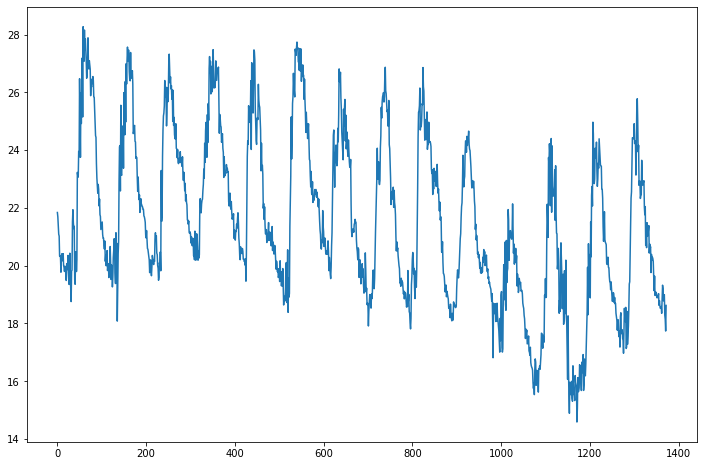

In [35]:
plt.figure(figsize= (12,8))
plt.plot(Final['Indoor_temperature_room']);

## **<span style='color:green'>8. Concluding remarks</span>**<a id ='Conclusion'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)
The training dataset and testing dataset come from different distributions due to data collection done in different months and since there exits a possibility  that test prediction values  lies outside the range of trained values, a linear regression seemed a right model for this data. The GAM model used seems a perfect fit with residues satisfying a i.i.d requirements and a mean error in the range of 0.7. 

## **<span style='color:green'>9. References:</span>**<a id ='References'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)

1. [What is Adversarial Validation?](https://www.kaggle.com/code/carlmcbrideellis/what-is-adversarial-validation/notebook)
2. [Multivariate time series forecasting: Linear-tree](https://www.kaggle.com/code/carlmcbrideellis/multivariate-time-series-forecasting-linear-tree)
3. [Building interpretable models with Generalized additive models in Python](https://medium.com/just-another-data-scientist/building-interpretable-models-with-generalized-additive-models-in-python-c4404eaf5515)
4. [pyGAM : Getting Started with Generalized Additive Models in Python](https://codeburst.io/pygam-getting-started-with-generalized-additive-models-in-python-457df5b4705f)


## **<span style='color:green'>10. Extension: LinearBoostRegressor</span>**<a id ='LinearBoostRegressor'></a>
[<div style="text-align: right"> Back to Table of contents</div>](#Table)



 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Linear Boost Regressor prediction : 0.5913011903952516
Mean Squared Error(MSE) of Linear Boost Regressor prediction : 0.7085779306535123
Root Mean Squared Error (RMSE) of Linear Boost Regressor prediction : 0.8417707114490931
Mean absolute percentage error (MAPE) of Linear Boost Regressor prediction : 0.032367043306224794
Explained Variance Score (EVS) of Linear Boost Regressor prediction : 0.9131661336455215
R2 of Linear Boost Regressor prediction : 0.91

 


 
 
 



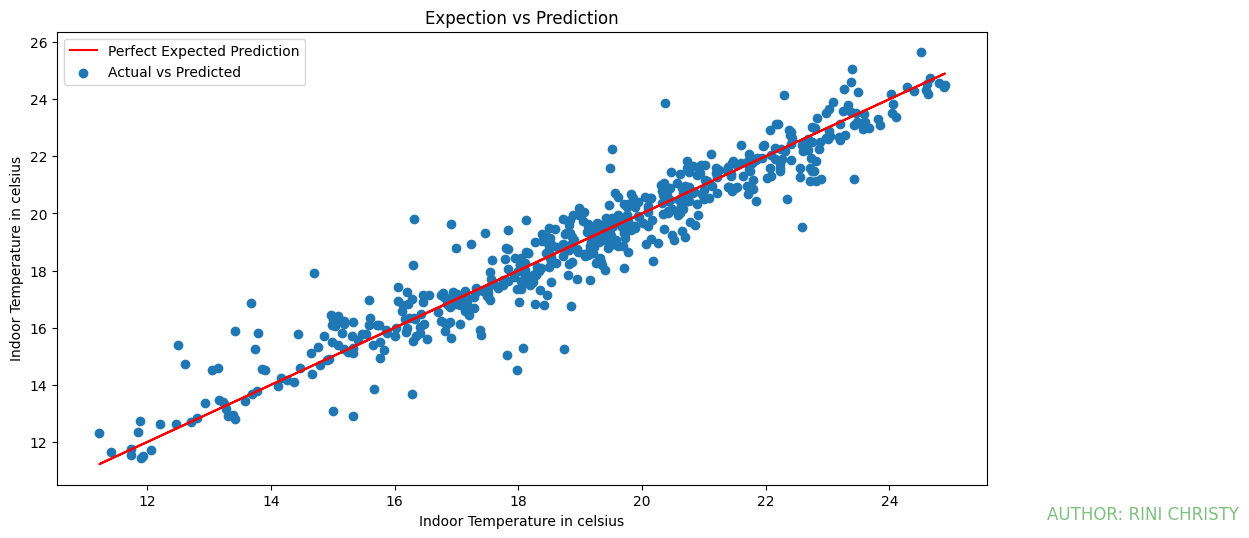

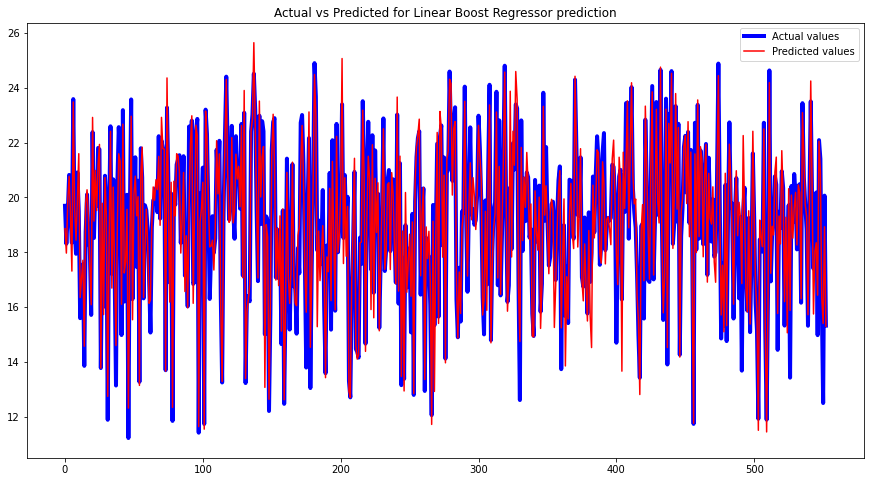

In [36]:
!pip install -q --upgrade linear-tree
from lineartree import LinearBoostRegressor
from sklearn.linear_model import LinearRegression
LB = LinearBoostRegressor(base_estimator=LinearRegression(), n_estimators = 600,random_state = 42)
LB.fit(X_train, y_train)
ypred = LB.predict(X_val)
model_train_evaluation(y_val, ypred, 'Linear Boost Regressor prediction')

,Id,Indoor_temperature_room
0,2764,25.455841
1,2765,25.512205
2,2766,25.087763
3,2767,25.087946
4,2768,25.003798
...,...,...
1368,4132,16.990887
1369,4133,16.866951
1370,4134,17.072063
1371,4135,17.212322


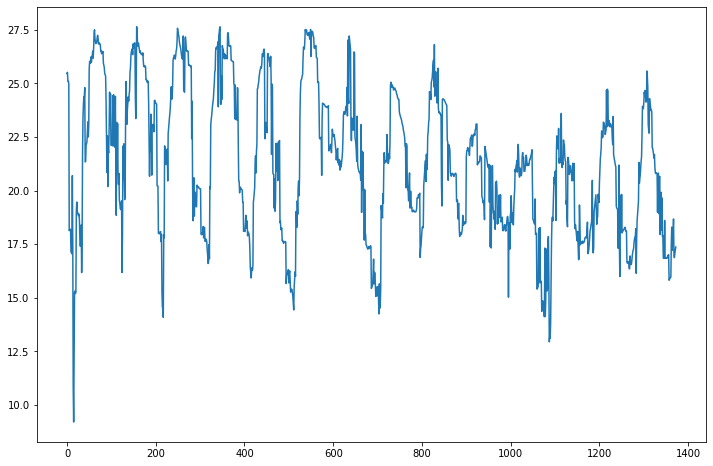

In [37]:
df_test['forecast'] = LB.predict(X_test)
#test['forecast'] = forecast
Final = df_test[['Id', 'forecast']]
Final.columns = ['Id', 'Indoor_temperature_room']
#Final.to_csv('submission1.csv', index = False)
plt.figure(figsize= (12,8))
plt.plot(Final['Indoor_temperature_room']);
Final

## **<span style='color:green'>11. Extension: All regression models in one frame:</span>**<a id ='regression'></a>

[<div style="text-align: right"> Back to Table of contents</div>](#Table)


In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
!pip install catboost --quiet
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
#!pip install -q --upgrade linear-tree
from lineartree import LinearBoostRegressor
from sklearn.neural_network import MLPRegressor
from pygam import LinearGAM
from sklearn import metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score

Models=[("Linear Regression",LinearRegression()),
        ("Ridge", Ridge()),
        ("Lasso", Lasso()),
        ("SGD", SGDRegressor ()),
        ("ElasticNet", ElasticNet()),
        ("KNR",KNeighborsRegressor()),
        ("Support Vector(SVR)",SVR()),
        ("Decision Tree",DecisionTreeRegressor()),
        ("Extra Trees",ExtraTreesRegressor()),
        ("Random Forest",RandomForestRegressor()),
        ("Bagging",BaggingRegressor()),
        ("AdaBoost",AdaBoostRegressor()),
        ("GradientBoosting",GradientBoostingRegressor()),
        ("Extreme Gradient Boosting(XGB)",XGBRegressor()),
        ("CatBoost",CatBoostRegressor(loss_function='RMSE', learning_rate = 0.1, max_depth = 5,  n_estimators = 100, silent = True)), 
        ("Light Gradient Boosting Machine(LGBM)", LGBMRegressor (boosting_type = 'gbdt', num_leaves = 31,  learning_rate = 0.1, max_depth = 5, n_estimators = 100, silent = True)),
        ("Linear Boosting", LinearBoostRegressor(base_estimator=LinearRegression(),n_estimators = 600,random_state = 42)),
        ('Hist gradient boosting(HGB)', HistGradientBoostingRegressor(min_samples_leaf=1)),
        ('Multi-layer Perceptron(MLP)', MLPRegressor(random_state=42, max_iter=400,hidden_layer_sizes=(64,32,16),activation="tanh",learning_rate_init=0.05)),
        ('Generalized Additive Model(GAM)', LinearGAM(n_splines=30))]

Model_output=[]
for name,model in Models:
    ypred=model.fit(X_train, y_train).predict(X_val)
    MAE = metrics.mean_absolute_error(y_val, ypred)
    MSE = metrics.mean_squared_error(y_val, ypred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_val, ypred))
    Explained_Variance_score= explained_variance_score(y_val, ypred)
    R2_score = r2_score(y_val, ypred)
    Train_set_MAE = metrics.mean_absolute_error(y_train, model.predict(X_train))
    Model_output.append((name, Train_set_MAE, MAE,MSE,RMSE, Explained_Variance_score,R2_score))
    final_Report=pd.DataFrame(Model_output, columns=['Algorithm','Train_set_MAE', 'MAE', 'MSE', 'RMSE', 'Explained_Variance_score','R2 score'])
final_Report = final_Report.sort_values('R2 score', ascending = False, ignore_index=True)       
final_Report

[14:59:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Algorithm,Train_set_MAE,MAE,MSE,RMSE,Explained_Variance_score,R2 score
0,Extra Trees,2.389686e-14,1.715442e-01,7.672308e-02,2.769893e-01,9.906290e-01,9.905916e-01
1,Hist gradient boosting(HGB),1.503232e-01,3.060779e-01,1.758502e-01,4.193450e-01,9.784956e-01,9.784359e-01
2,Random Forest,1.158028e-01,2.667089e-01,1.834366e-01,4.282950e-01,9.776347e-01,9.775056e-01
3,Bagging,1.340976e-01,2.984045e-01,2.328634e-01,4.825592e-01,9.715887e-01,9.714445e-01
4,Light Gradient Boosting Machine(LGBM),2.759000e-01,3.942212e-01,2.684092e-01,5.180822e-01,9.672121e-01,9.670857e-01
5,Decision Tree,0.000000e+00,3.443718e-01,4.707295e-01,6.860973e-01,9.425534e-01,9.422756e-01
6,CatBoost,5.034763e-01,5.573626e-01,4.921096e-01,7.015052e-01,9.398855e-01,9.396538e-01
7,GradientBoosting,5.235164e-01,6.060279e-01,5.904553e-01,7.684109e-01,9.277802e-01,9.275939e-01
8,Extreme Gradient Boosting(XGB),5.203801e-01,6.007912e-01,5.939934e-01,7.707097e-01,9.273653e-01,9.271601e-01
9,Linear Boosting,3.872227e-01,5.913012e-01,7.085779e-01,8.417707e-01,9.131661e-01,9.131089e-01


In [39]:
%%html
<marquee style=’width: 90%; height:70%; color: #0bda11;’>
    <b> Thanks for reading. Hope you enjoyed it as much as I did working on it.  Please consider upvoting if you like it.</b></marquee>